In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
%matplotlib inline

In [4]:
raw_df = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False, sep=',')
df = raw_df.loc[:, ['Sentiment', 'SentimentText']]
df.head()

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [41]:
df.groupby('Sentiment').describe()

SentimentText                                                       \
                  count  unique                                          top   
Sentiment                                                                      
0                788435  788435  @mcraddictal No you aren't honey  ILY &lt;3   
1                790177  790177               @Uncle_Trav not following me?    

                
          freq  
Sentiment       
0            1  
1            1

In [42]:
df_positive = df[df['Sentiment']>0]
df_negative = df[df['Sentiment']==0]

In [43]:
df_negative.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?


In [44]:
def get_top_n_words(data, n):
    # Use CountVectorizer to get Baf-Of-Words. Remove stop words and punctuation
    count_vect = CountVectorizer(stop_words='english').fit(data)
    bag_of_words = count_vect.transform(data)

    sum_words = bag_of_words.sum(axis=0)
    # Sort words in corpus by their frequency
    freq = [(word, sum_words[0, i]) for word, i in count_vect.vocabulary_.items()]
    freq = sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

In [45]:
# TOP 10 positive words
get_top_n_words(df_positive['SentimentText'], 10)

[('just', 62422),
 ('good', 60795),
 ('love', 47573),
 ('http', 46223),
 ('day', 45951),
 ('quot', 45471),
 ('like', 37451),
 ('lol', 36000),
 ('com', 34833),
 ('thanks', 34434)]

In [46]:
# TOP 10 negative words
get_top_n_words(df_negative['SentimentText'], 10)

[('just', 63795),
 ('work', 44065),
 ('like', 40882),
 ('day', 39498),
 ('today', 37859),
 ('going', 33416),
 ('got', 33031),
 ('don', 32526),
 ('really', 31172),
 ('im', 30987)]

In [11]:
# TOP 10 negative words
# negative_freq[:10]

[('just', 63795),
 ('work', 44065),
 ('like', 40882),
 ('day', 39498),
 ('today', 37859),
 ('going', 33416),
 ('got', 33031),
 ('don', 32526),
 ('really', 31172),
 ('im', 30987)]

# Zipf law
Zipf law basically says that if we sort all words in some language by their frequency from the most frequent to the least, we will see that frequency value will be reduced almost in the same proportions like word's rank.
For example frequency value of the 3rd word will be 3 times smaller than frequency value of the 1st word.

In [5]:
# TOP words from the whole corpus
count_vect = CountVectorizer(stop_words='english').fit(df['SentimentText'])
bag_of_words = count_vect.transform(df['SentimentText'])
sum_of_words = bag_of_words.sum(axis=0)
word_freq = [sum_of_words[0, i] for _, i in count_vect.vocabulary_.items()]
word_freq.sort(reverse=True)

In [6]:
ranks = list(range(1, 31))

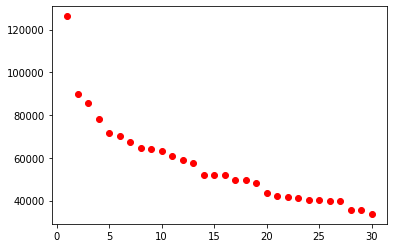

In [8]:
plt.plot(ranks, word_freq[:30], 'ro')
plt.show()

We could see that chart shows that Zipf law works not as good as we expected. 3rd word frequency is not 3 times smaller than 1st. If we don't remove stop words from the corpus results are a little bit better but not ideal.
I think this belongs to the size of the dataset, words uniqueness and specific slang in the comments (when we have a lot of different word's spelling etc)

## Simple Sentiment Analysis

In [18]:
df.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [8]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
texts = df['SentimentText'].values
y = df['Sentiment'].values
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.1)

In [10]:
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts_train)

X_train_tokenized = tokenizer.texts_to_sequences(texts_train)
X_test_tokenized = tokenizer.texts_to_sequences(texts_test)

In [11]:
maxlen = 100
X_train = pad_sequences(X_train_tokenized, maxlen=maxlen)
X_test = pad_sequences(X_test_tokenized, maxlen=maxlen)

In [12]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

644089

In [13]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPool1D, Dropout

In [14]:
inp = Input(shape=(maxlen, ))

x = Embedding(max_features, 128)(inp)

# use LSTM for our neural network as a nice common way to work with embeddings
x = LSTM(60, return_sequences=True)(x)

# reduce size
x = GlobalMaxPool1D()(x)

# helps to prevent overfitting
x = Dropout(0.1)(x)

# just workers :)
x = Dense(50, activation="relu")(x)

x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model = Model(inputs=inp, outputs=x)

In [16]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [20]:
batch_size = 32
epochs = 1
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 1278675 samples, validate on 142075 samples
Epoch 1/1
1278675/1278675 [==============================] - 4174s 3ms/step - loss: 0.4127 - acc: 0.8110 - val_loss: 0.4011 - val_acc: 0.8172


In [27]:
inp = pad_sequences(tokenizer.texts_to_sequences(["I love you"]), maxlen=maxlen)
dict(zip([1, 0], model.predict(inp)[0]))

{1: 0.9346451}

In [35]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)

In [36]:
print(loss)

0.38556106567475107


In [37]:
print(accuracy)

0.8251951434102546


## How to impove this model:
- Use bigger dataset. Size of the dataset is crucial for the NN
- Use pretrained Embeddings like Word2Vec
- Play with hyperparameters. Grid search helps here, but we should use much powerful computers and GPU to reduce training time.
- Try different model's architecture (without LSTM, more Dense layers)